#### Importing Libraries

In [1]:
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import time
from sortedcontainers import SortedSet # Used for fringe in A star
import queue
from collections import deque 
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.patches as mpatches

### -----------------------------------------------------------------------------------------------------------------------------

#### Grid and Cell class

In [2]:
# Class cell -> its the class of all the nodes in the grid, Each cell of the grid is defined as a object of type 
# cell.
class cell:
    def __init__(self,x,y): # Constructor for class cell
        self.x = x # x coordinate of the cell
        self.y = y # y coordinate of the cell
        self.g = 0 # g value of the cell (the distance from start cell to curr cell)
        self.h = 0 # h value of the cell (estimated value of the distance between curr cell and goal cell)
        self.f = 0 # f value of the cell (f = g+h in A*, defines the priority of a node)
        self.blocked = False
        self.terrain = None
        self.false_neg_rate = 0
        self.prob_of_containing_target = 0
        
    def set_h_value(self, g_x, g_y, heuristic, weight):
        '''This function is used to assign the heuristic value i.e. the h value and the f value to the calling 
           class object. It takes in the argument g_x = goal cell abscissa, g_y = goal cell ordinate, 
           heuristic = It defines the type of heuristic the A* problem is using, weight = this is for problem 
           number 9 where we test the effect of weights on the performance of repeated A* and normal A*.'''
        if heuristic == 'm': 
            # Manhattan distance
            self.h = weight * abs(g_x - self.x) + abs(g_y - self.y)
            self.f = self.g + self.h # also updating f inside this function
        if heuristic == 'e':
            # euclidean distance
            self.h = weight * math.sqrt((g_x - self.x)**2 + (g_y - self.y)**2)
            self.f = self.g + self.h
        if heuristic == 'c':
            # chebyshev distance
            self.h = weight * max(abs(g_x - self.x), abs(g_y - self.y))
            self.f = self.g + self.h
        if heuristic == 'dec_weight_m':
            # dec_weight_m manhattan distance is used as the heuristic
            # Adaptive weight technique, nodes nearer to the goal cell are assigned lower weight and nodes farther
            # away from the goal cell are assigned greater weights.
            self.h = abs(g_x - self.x) + abs(g_y - self.y)
            # if g < (2w-1)h then reduce the weight of g else reduce the weights of both g and h
            if self.g < (2*weight - 1) * self.h: 
                self.f = self.g / (2*weight - 1) + self.h
            else:
                self.f = (self.g + self.h) / weight 
        if heuristic == 'dec_weight_e':
            # dec_weight_e euclidean distance is used as the heuristic
            self.h = math.sqrt((g_x - self.x)**2 + (g_y - self.y)**2)
            # same exp as in dec_weight_m
            if self.g < (2*weight - 1) * self.h:
                self.f = self.g / (2*weight - 1) + self.h
            else:
                self.f = (self.g + self.h) / weight
        if heuristic == 'dec_weight_c':
            # chebyshev distance is used as the heuristic
            self.h = max(abs(g_x - self.x), abs(g_y - self.y))
            # same explanation as dec_weight_m
            if self.g < (2*weight - 1) * self.h:
                self.f = self.g / (2*weight - 1) + self.h
            else:
                self.f = (self.g + self.h) / weight
        if heuristic == 'inc_weight_m':
            # This is also an adaptive weight technique, but instead of decreasing weight as we move along the 
            # path, we assign more weight to h.
            self.h = abs(g_x - self.x) + abs(g_y - self.y)
            if self.g < self.h:
                self.f = self.g + self.h
            else:
                self.f = self.g + (2*weight-1)*self.h 
        if heuristic == 'g':
            # Toal greedy approach used in q4 to compare the speeds of A* and greedy best first search algorithm.
            # manhattan distance is used as heuristic
            self.h = abs(g_x - self.x) + abs(g_y - self.y)
            self.f = self.h

In [3]:
# Class grid_world -> This class is used to generate a grid world of dimension dim with each cell having 
# probability p of being blocked.
class grid_world:
    def __init__(self,p,dim):
        self.p = p # probability with which the cell is blocked
        self.dim = dim # dimension of the grid (dim x dim)
    def gen_grid(self,matrix):
        '''This function is used to generate the grid. The grid is returned in the form of list of list.'''
        for i in range(self.dim): # looping over the dimension to generate rows of cells
            a = [] # store a row of the grid of len dim
            for j in range(self.dim): # looping over the dim to generate cols of cells
                c = cell(i,j) # cell for coordinates (i,j)
                chance = random.uniform(0,1) 
                # generating a random number between 0 and 1 from uniform distribution, if its less than p 
                # the cell is blocked else the cell is unblocked.
                # if the number generated is less than or equal to p, block the cell.
                if(chance <= self.p):
                    c.blocked = True
                else:
                    if(self.p!= 1 and self.p!= 0):
                        x = random.randint(1,3)
                        if(x==1):
                            c.terrain = 'flat'
                            c.false_neg_rate = 0.2
                        elif x == 2:
                            c.terrain = 'hill'
                            c.false_neg_rate = 0.5
                        else:
                            c.terrain = 'Forest'
                            c.false_neg_rate = 0.8
                    
                a.append(c) # append the cell to the row
                
            matrix.append(a) # append the row to the grid
        if(self.p!= 1 and self.p!= 0):
            while(True):
                start_cell_x = random.randint(0,self.dim-1)
                start_cell_y = random.randint(0,self.dim-1)

                if matrix[start_cell_x][start_cell_y].blocked == True:
                    continue

                target_x = random.randint(0,self.dim-1)
                target_y = random.randint(0,self.dim-1)

                if matrix[target_x][target_y].blocked == True:
                    continue

                break
        
            return matrix, (start_cell_x, start_cell_y), (target_x, target_y) # return the final grid
        else:
            return matrix

In [4]:
def gen_env(p, dim):
    '''Function to generate the enviornment with probability of blockage p and dimension = dim x dim'''
    temp = grid_world(p, dim)
    if (p!= 1 and p!= 0):
        grid, start_cell_ind, target_ind = temp.gen_grid([])
        return grid, start_cell_ind, target_ind
    else:
        grid = temp.gen_grid([])
        return grid

In [5]:
def disp_grid(grid):
    '''Since our grid is a list of list of cells simply printing it does not work. This function prints the 
    grid with blockage as x and a cell on which we can travel as -'''
    l = []
    for i in range(len(grid)):
        a = []
        for j in range(len(grid)):
            if grid[i][j].blocked:
                a.append('x')
            else:
                a.append('-')
        l.append(a)
    return l

In [6]:
real_world_grid, start_cell_ind, target_ind = gen_env(0.3,10)

In [7]:
bot_env = gen_env(0,10)

In [8]:
final_discovered_gridworld = gen_env(1,10)

In [9]:
disp_grid(real_world_grid)

[['-', '-', '-', '-', '-', 'x', '-', '-', 'x', '-'],
 ['x', '-', '-', '-', '-', '-', '-', '-', '-', '-'],
 ['-', 'x', 'x', '-', '-', '-', 'x', '-', '-', '-'],
 ['x', '-', '-', '-', '-', '-', '-', '-', 'x', '-'],
 ['-', '-', 'x', '-', 'x', '-', '-', '-', 'x', '-'],
 ['-', '-', 'x', '-', '-', 'x', '-', '-', '-', 'x'],
 ['x', '-', '-', '-', 'x', '-', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', 'x', '-', '-', '-', '-'],
 ['-', '-', '-', '-', '-', '-', 'x', '-', '-', '-'],
 ['-', '-', 'x', '-', 'x', 'x', '-', '-', '-', '-']]

In [10]:
start_cell_ind

(5, 0)

In [11]:
target_ind

(4, 6)

### -----------------------------------------------------------------------------------------------------------------------------

#### Helper functions

In [12]:
def assign_initial_probability(grid):
    num = 1
    den = len(grid)*len(grid)
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            grid[i][j].prob_of_containing_target = num/den

In [13]:
assign_initial_probability(bot_env)

In [14]:
def disp_prob_of_grid(grid):
    l = []
    for i in range(len(grid)):
        a = []
        for j in range(len(grid)):
            a.append(grid[i][j].prob_of_containing_target)
        l.append(a)
    return l

In [15]:
disp_prob_of_grid(bot_env)

[[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
 [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
 [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
 [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
 [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
 [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
 [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
 [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
 [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
 [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]]

In [16]:
def assign_new_probability_when_target_not_found(grid, cell_x, cell_y):
    FN = grid[cell_x][cell_y].false_neg_rate
    prob_of_containing_x_y = grid[cell_x][cell_y].prob_of_containing_target
    den = 0
    
    for i in range(len(grid)):
        for j in range(len(grid)):
            if(grid[i][j].blocked):
                continue
            if (i == cell_x and j == cell_y):
                den += grid[cell_x][cell_y].prob_of_containing_target * grid[cell_x][cell_y].false_neg_rate
            else:
                den += grid[i][j].prob_of_containing_target
            
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            if(grid[i][j].blocked):
                continue
            else:
                prob_of_containing = grid[i][j].prob_of_containing_target
                if(i == cell_x and j == cell_y):
                    grid[i][j].prob_of_containing_target = (prob_of_containing_x_y*FN)/den
                else:
                    grid[i][j].prob_of_containing_target = prob_of_containing/den

In [17]:
assign_new_probability_when_target_not_found(bot_env, 1, 3)

In [18]:
disp_prob_of_grid(bot_env)

[[0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095],
 [0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.0,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095],
 [0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095],
 [0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095,
  0.010101010101010095],
 [0.010101010101010095,
  0.010101010101010095,
  0.0

In [19]:
def assign_new_probability_when_new_block_disc(grid, cell_x, cell_y):
    prob_of_containing_x_y = grid[cell_x][cell_y].prob_of_containing_target
    den = 0
    
    for i in range(len(grid)):
        for j in range(len(grid)):
            if(grid[i][j].blocked):
                continue
            if (i == cell_x and j == cell_y):
                continue
            else:
                den += grid[i][j].prob_of_containing_target
    
    
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            if (i== cell_x and j== cell_y):
                grid[i][j].prob_of_containing_target = 0
            else:
                if(grid[i][j].blocked):
                    continue
                else:
                    prob_of_containing = grid[i][j].prob_of_containing_target
                    grid[i][j].prob_of_containing_target = prob_of_containing/den

In [20]:
assign_new_probability_when_new_block_disc(bot_env,0,3)

In [21]:
disp_prob_of_grid(bot_env)

[[0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308],
 [0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.0,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308],
 [0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308],
 [0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308],
 [0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265308,
  0.01020408163265

In [22]:
def choose_next_goal_cell(grid, cell_x, cell_y):
    min_dist = math.inf
    target = []
    max_prob = 0
    max_prob_ind = []
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            if(i == cell_x and j == cell_y):
                continue
            if grid[i][j].prob_of_containing_target > max_prob:
                max_prob = grid[i][j].prob_of_containing_target
                max_prob_ind = [[i,j]]
            elif grid[i][j].prob_of_containing_target == max_prob:
                max_prob_ind.append([i,j])    

    for l in max_prob_ind:
        if abs(cell_x - l[0]) + abs(cell_y - l[1]) < min_dist:
            min_dist = abs(cell_x - l[0]) + abs(cell_y - l[1])
            target = [l]
        elif abs(cell_x - l[0]) + abs(cell_y - l[1]) == min_dist:
            target.append(l)
    return target

In [23]:
def choose_next_goal_cell_agent7(grid, cell_x, cell_y):
    min_dist = math.inf
    target = []
    max_prob = 0
    max_prob_ind = []
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            if(i == cell_x and j == cell_y):
                continue
            if grid[i][j].prob_of_containing_target*(1-grid[i][j].false_neg_rate) > max_prob:
                max_prob = grid[i][j].prob_of_containing_target*(1-grid[i][j].false_neg_rate)
                max_prob_ind = [[i,j]]
            elif grid[i][j].prob_of_containing_target*(1-grid[i][j].false_neg_rate) == max_prob:
                max_prob_ind.append([i,j])    

    for l in max_prob_ind:
        if abs(cell_x - l[0]) + abs(cell_y - l[1]) < min_dist:
            min_dist = abs(cell_x - l[0]) + abs(cell_y - l[1])
            target = [l]
        elif abs(cell_x - l[0]) + abs(cell_y - l[1]) == min_dist:
            target.append(l)
    return target

In [24]:
def choose_next_goal_cell_agent8(grid, cell_x, cell_y):
    min_dist = math.inf
    target = []
    max_utility = 0
    max_utility_ind = []
    #max_dist = 2*len(grid)-2
    max_dist = 200
    
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            if(i==cell_x and j == cell_y):
                continue
            p = grid[i][j].prob_of_containing_target
            FN = grid[i][j].false_neg_rate
            dist = abs(cell_x - i) + abs(cell_y - j)
            if p*(1-FN)*max_dist/dist > max_utility:
                
                max_utility = p*(1-FN)*max_dist/dist
                max_utility_ind = [[i,j]]
            elif p*(1-FN)*max_dist/dist == max_utility:
                max_utility_ind.append([i,j])    

#     max_prob = 0
#     for l in max_utility_ind:
#         if grid[l[0]][l[1]].prob_of_containing_target*(1-grid[l[0]][l[1]].false_neg_rate) > max_prob:
#             max_prob = grid[l[0]][l[1]].prob_of_containing_target*(1-grid[l[0]][l[1]].false_neg_rate)
#             target = [l]
#         elif grid[l[0]][l[1]].prob_of_containing_target*(1-grid[l[0]][l[1]].false_neg_rate) == max_prob:
#             target.append(l)
#     return target
    
    for l in max_utility_ind:
        if abs(cell_x - l[0]) + abs(cell_y - l[1]) < min_dist:
            min_dist = abs(cell_x - l[0]) + abs(cell_y - l[1])
            target = [l]
        elif abs(cell_x - l[0]) + abs(cell_y - l[1]) == min_dist:
            target.append(l)
    return target

In [25]:
choose_next_goal_cell(bot_env, 0, 0)

[[0, 1], [1, 0]]

In [26]:
def find_target_in_goal_cell(grid,cell_x,cell_y,target_cell):
    if((cell_x, cell_y) == target_cell):
        chance = random.uniform(0,1)
        if chance <= grid[cell_x][cell_y].false_neg_rate:
            return False
        else:
            return True
    else:
        return False

In [27]:
#function to print path
def print_path(paths, start_cell_ind):
    '''
    Function to print the path also we use it to get the final trajectory with backtracking taken by the agent. 
    '''
    l = [list(start_cell_ind)] # start from [0,0]
    for path in paths: 
        l.extend(path[1:]) # extend the list with values of path 
    return l

In [28]:
def is_solvable(grid,start_cell_ind,target_ind):
    p = Astar(real_world_grid,start_cell_ind,target_ind,'m')
    if p[0] == []:
        return False
    else:
        return True

### -----------------------------------------------------------------------------------------------------------------------------

#### Astar

In [29]:
def Astar(grid,start_cell_ind,goal_cell_ind, heuristic, weight = 1):
    cells_processed = 0 # number of cells popped from the fringe before reaching the goal.
    number_of_clashes = 0 # number of time we had to update priorities in the fringe.
    start_cell = grid[start_cell_ind[0]][start_cell_ind[1]] # start cell of our grid.
    goal_cell = grid[goal_cell_ind[0]][goal_cell_ind[1]] # goal cell of our grid
    open_list = SortedSet() # fringe, we have used sorted set as our priority queue
    close_list = set() # contains cells already processed, have used set for this purpose (O(1) lookup on average)
    parent_dict = {} # stores parent child relationship, using dictionary for this
    visited = set() # child already visited, using set for this purpose (O(1) lookup on average)
    start_cell.g = 0 # Setting the g value of the start cell to 0
    # setting the h and f value of the start cell using the weight and heuristic passed in the function arguments.
    # weight is for q9
    start_cell.set_h_value(goal_cell_ind[0], goal_cell_ind[1], heuristic, weight)
    open_list.add((start_cell.f, start_cell.h, (start_cell.x, start_cell.y))) # adding the start cell to the priority queue
    # In the queue we are pushing a tuple whose first coordinate is the f value, second coordinate is the h value 
    # then a tuple containing the location of the cell. The priority is set according to the f value in case of a 
    # tie h value is seen.
    visited.add((start_cell.x, start_cell.y)) # updating the visited set as we are pushing the node in priority queue
    while len(open_list)>0: # loop over the priority queue until it is not empty or we reach the goal node
        cl = open_list.pop(0) # pop the node with the least priority (it is at index 0 in the sorted set)
        curr_cell = grid[cl[-1][0]][cl[-1][1]] # the last index in cl contains the x and y coordinates, 
        # storing the node popped from the queue in curr_cell.
        cells_processed += 1 # incrementing the number of cells processed (since we just popped from the queue)
        close_list.add((curr_cell.x, curr_cell.y)) # adding the node to the closed list as it is about to be processed
        if curr_cell == goal_cell: 
            # If the curr cell is the goal cell return the path from the curr cell to goal cell by backtracking 
            # from goal cell to curr cell using the parent dictionary as well as all the nodes 
            # that have been processed uptil now.
            path = []
            curr = curr_cell
            while (curr.x, curr.y) != (start_cell_ind[0], start_cell_ind[1]):
                path.append([curr.x, curr.y])
                curr = parent_dict[(curr.x, curr.y)]
            path.append([curr.x,curr.y])
            return path[::-1], cells_processed, number_of_clashes
        
        children = [] # This list is used to store all the possible valid children of the cell 
        # currently being processed.
        for new_pos in [(0,1),(0,-1),(1,0),(-1,0)]: # 4 main compass directions, field of view also the agent can 
            # only move to these locations
            node_pos = (curr_cell.x+new_pos[0], curr_cell.y+new_pos[1]) # position of the child
            if(node_pos[0] > len(grid)-1 or node_pos[1] > len(grid)-1 or node_pos[0] < 0 or node_pos[1] < 0):
                # if the child is not part of the grid continue
                continue
            if(grid[node_pos[0]][node_pos[1]].blocked):
                # if the child is blocked continue
                continue
            if((node_pos[0], node_pos[1]) in close_list):
                # if child is in close list continue
                continue
            if((node_pos[0], node_pos[1]) in visited):
                # if the child is already visited then compare the previous cost(f) to the new cost(f) and if the
                # new cost is lower update the priority of the child in the priority queue, update the 
                # parent dictionary and update the g value of the node.
                if curr_cell.g + 1 + grid[node_pos[0]][node_pos[1]].h < grid[node_pos[0]][node_pos[1]].f:
                    number_of_clashes += 1 # increment the number of clashes by 1
                    # To update the priority we remove the node from the sorted set (O(logn)) and reinsert with 
                    # new priority O(log(n)). 
                    open_list.remove((grid[node_pos[0]][node_pos[1]].f, grid[node_pos[0]][node_pos[1]].h, (grid[node_pos[0]][node_pos[1]].x, grid[node_pos[0]][node_pos[1]].y)))
                    grid[node_pos[0]][node_pos[1]].g = curr_cell.g+1
                    grid[node_pos[0]][node_pos[1]].set_h_value(goal_cell_ind[0], goal_cell_ind[1], heuristic, weight)
                    open_list.add((grid[node_pos[0]][node_pos[1]].f, grid[node_pos[0]][node_pos[1]].h, (grid[node_pos[0]][node_pos[1]].x, grid[node_pos[0]][node_pos[1]].y)))
                    parent_dict[(node_pos[0],node_pos[1])] = curr_cell # updating the parent dictionary
            else:
                # If the child is not visited update its g value, set its h and f value and add it to the 
                # children list after updating its parent.
                grid[node_pos[0]][node_pos[1]].g = curr_cell.g + 1
                grid[node_pos[0]][node_pos[1]].set_h_value(goal_cell_ind[0], goal_cell_ind[1], heuristic, weight)
                children.append(grid[node_pos[0]][node_pos[1]])
                parent_dict[(node_pos[0],node_pos[1])] = curr_cell
        if(children == []): # If no valid child continue
            continue
        for child in children: # else if valid children exist add them to the open list and update the visited set.
            open_list.add((child.f,child.h, (child.x, child.y)))
            visited.add((child.x, child.y))
    
    return [], 0, 0

### ------------------------------------------------------------------------------------------------------------------------------

#### Explore path function

In [30]:
#function to explore path returned by A* algorithm with limited field of view (the bot can only see in the direction of its movement along the path). 
def explore_path_with_limited_view(path,bot_env ,grid, final_discovered_grid_world, examine_cost, target_cell_ind, movement_cost):
    '''
    This function helps move the agent along the path returned by A* with unidirectional field of view. The bot environment
    and final discovered grid world are updated with status of cells along the path traversed.
    '''
    x = 0
    y = 0
    for i in range(len(path)): #looping over path list
        x = path[i][0] # x coordinate of the current node
        y = path[i][1] # y coordinate of the current node
        movement_cost += 1
        #update the bot environment and final discovered grid 
        bot_env[x][y].x = grid[x][y].x 
        bot_env[x][y].y = grid[x][y].y
        bot_env[x][y].blocked = grid[x][y].blocked
        bot_env[x][y].terrain = grid[x][y].terrain
        bot_env[x][y].false_neg_rate = grid[x][y].false_neg_rate
        
        final_discovered_grid_world[x][y].x = grid[x][y].x
        final_discovered_grid_world[x][y].y = grid[x][y].y
        final_discovered_grid_world[x][y].blocked = grid[x][y].blocked
        final_discovered_grid_world[x][y].terrain = grid[x][y].terrain
        final_discovered_grid_world[x][y].false_neg_rate = grid[x][y].false_neg_rate
        
        if(grid[x][y].blocked): #if the current node is blocked node, return the path traversed till now.
            movement_cost -= 1
            assign_new_probability_when_new_block_disc(bot_env,x,y)
            candidate_targets = choose_next_goal_cell(bot_env,path[i-1][0],path[i-1][1])
            tar_ind = random.choice(candidate_targets)
            new_goal_cell = tar_ind
            return path[:i], new_goal_cell, False, examine_cost, movement_cost
    
    if find_target_in_goal_cell(bot_env,x,y, target_cell_ind):
        examine_cost += 1
        return path, True, examine_cost, movement_cost
    else:
        examine_cost += 1
        assign_new_probability_when_target_not_found(bot_env, x, y)
        candidate_targets = choose_next_goal_cell(bot_env,x,y)
        tar_ind = random.choice(candidate_targets)
        new_goal_cell = tar_ind
        return path, new_goal_cell ,False, examine_cost, movement_cost

#### Explore path agent 7

In [31]:
#function to explore path returned by A* algorithm with limited field of view (the bot can only see in the direction of its movement along the path). 
def explore_path_with_limited_view_agent_7(path,bot_env ,grid, final_discovered_grid_world, examine_cost, target_cell_ind, movement_cost):
    '''
    This function helps move the agent along the path returned by A* with unidirectional field of view. The bot environment
    and final discovered grid world are updated with status of cells along the path traversed.
    '''
    x = 0
    y = 0
    for i in range(len(path)): #looping over path list
        x = path[i][0] # x coordinate of the current node
        y = path[i][1] # y coordinate of the current node
        movement_cost += 1
        #update the bot environment and final discovered grid 
        bot_env[x][y].x = grid[x][y].x 
        bot_env[x][y].y = grid[x][y].y
        bot_env[x][y].blocked = grid[x][y].blocked
        bot_env[x][y].terrain = grid[x][y].terrain
        bot_env[x][y].false_neg_rate = grid[x][y].false_neg_rate
        
        final_discovered_grid_world[x][y].x = grid[x][y].x
        final_discovered_grid_world[x][y].y = grid[x][y].y
        final_discovered_grid_world[x][y].blocked = grid[x][y].blocked
        final_discovered_grid_world[x][y].terrain = grid[x][y].terrain
        final_discovered_grid_world[x][y].false_neg_rate = grid[x][y].false_neg_rate
        
        if(grid[x][y].blocked): #if the current node is blocked node, return the path traversed till now.
            movement_cost -= 1
            assign_new_probability_when_new_block_disc(bot_env,x,y)
            candidate_targets = choose_next_goal_cell_agent7(bot_env,path[i-1][0],path[i-1][1])
            tar_ind = random.choice(candidate_targets)
            new_goal_cell = tar_ind
            return path[:i], new_goal_cell, False, examine_cost, movement_cost
    
    if find_target_in_goal_cell(bot_env,x,y, target_cell_ind):
        examine_cost += 1
        return path, True, examine_cost, movement_cost
    else:
        examine_cost += 1
        assign_new_probability_when_target_not_found(bot_env, x, y)
        candidate_targets = choose_next_goal_cell_agent7(bot_env,x,y)
        tar_ind = random.choice(candidate_targets)
        new_goal_cell = tar_ind
        return path, new_goal_cell ,False, examine_cost, movement_cost

#### Explore path agent 8

In [32]:
#function to explore path returned by A* algorithm with limited field of view (the bot can only see in the direction of its movement along the path). 
def explore_path_with_limited_view_agent_8(path,bot_env ,grid, final_discovered_grid_world, examine_cost, target_cell_ind, movement_cost):
    '''
    This function helps move the agent along the path returned by A* with unidirectional field of view. The bot environment
    and final discovered grid world are updated with status of cells along the path traversed.
    '''
    x = 0
    y = 0
    for i in range(len(path)): #looping over path list
        x = path[i][0] # x coordinate of the current node
        y = path[i][1] # y coordinate of the current node
        movement_cost += 1
        #update the bot environment and final discovered grid 
        bot_env[x][y].x = grid[x][y].x 
        bot_env[x][y].y = grid[x][y].y
        bot_env[x][y].blocked = grid[x][y].blocked
        bot_env[x][y].terrain = grid[x][y].terrain
        bot_env[x][y].false_neg_rate = grid[x][y].false_neg_rate
        
        final_discovered_grid_world[x][y].x = grid[x][y].x
        final_discovered_grid_world[x][y].y = grid[x][y].y
        final_discovered_grid_world[x][y].blocked = grid[x][y].blocked
        final_discovered_grid_world[x][y].terrain = grid[x][y].terrain
        final_discovered_grid_world[x][y].false_neg_rate = grid[x][y].false_neg_rate
        
        if(grid[x][y].blocked): #if the current node is blocked node, return the path traversed till now.
            movement_cost -= 1
            assign_new_probability_when_new_block_disc(bot_env,x,y)
            candidate_targets = choose_next_goal_cell_agent8(bot_env,path[i-1][0],path[i-1][1])
            tar_ind = random.choice(candidate_targets)
            new_goal_cell = tar_ind
            return path[:i], new_goal_cell, False, examine_cost, movement_cost
    
    if find_target_in_goal_cell(bot_env,x,y, target_cell_ind):
        examine_cost += 1
        return path, True, examine_cost, movement_cost
    else:
        examine_cost += 1
        assign_new_probability_when_target_not_found(bot_env, x, y)
        candidate_targets = choose_next_goal_cell_agent8(bot_env,x,y)
        tar_ind = random.choice(candidate_targets)
        new_goal_cell = tar_ind
        return path, new_goal_cell ,False, examine_cost, movement_cost

### ------------------------------------------------------------------------------------------------------------------------------

#### Repeated A*

In [33]:
# function to implement the A* algorithm
def repeated_astar(bot_env, real_world_grid, start_cell_ind,target_cell_ind, heuristic, final_discovered_grid_world, weight=1, agent_type = None):
    '''
    This function is the implementation of the repeated A* algorithm. This function calls A* algorithm whenver a 
    blocked cell is encountered along the path returned by A*.
    '''
    count = 0
    paths = [] # stores the path to be returned.
    cp = 0  # keeps count of the total number of cells processed in each A* call.
    #while the A* algorithm doesn't return a path or the maze is found to be not solvable     
    planning_time = 0
    nodes_disc = 0
    assign_initial_probability(bot_env)
    if agent_type == 6:
        goal_cell_ind = random.choice(choose_next_goal_cell(bot_env, start_cell_ind[0], start_cell_ind[1]))
        
    elif agent_type == 7:
        goal_cell_ind = random.choice(choose_next_goal_cell_agent7(bot_env, start_cell_ind[0], start_cell_ind[1]))
    else:
        goal_cell_ind = random.choice(choose_next_goal_cell_agent8(bot_env, start_cell_ind[0], start_cell_ind[1]))
    examine_cost = 0
    movement_cost = -1
    while(1):
#         print()
#         print(disp_prob_of_grid(bot_env))
#         s = 0
#         for i in range(len(bot_env)):
#             for j in range(len(bot_env[i])):
#                 s+= bot_env[i][j].prob_of_containing_target
#         print("Sum of prob:",s)
        count += 1
        t = time.time()
        path, cells_processed, n_c = Astar(bot_env, start_cell_ind, goal_cell_ind, heuristic, weight) # call A* with current knowledge of the grid
        planning_time += time.time() - t
        cp += cells_processed # add the number of cells processed to the variable cp which keeps the total number of cells processed for each iteration of A*
        
#         print("Path:", path)
#         print("start_cell_ind:", start_cell_ind)
#         print("goal_cell_ind:", goal_cell_ind)
        
        if(path == []): # If A* doesn't return a path, path doesn't exist. Break from the loop and print "Maze is not solvable"
            
#             print("Path returned Empty")
            bot_env[goal_cell_ind[0]][goal_cell_ind[1]].blocked = True
            bot_env[goal_cell_ind[0]][goal_cell_ind[1]].terrain = None
            bot_env[goal_cell_ind[0]][goal_cell_ind[1]].false_neg_rate = 0
        
            final_discovered_grid_world[goal_cell_ind[0]][goal_cell_ind[1]].blocked = True
            final_discovered_grid_world[goal_cell_ind[0]][goal_cell_ind[1]].terrain = None
            final_discovered_grid_world[goal_cell_ind[0]][goal_cell_ind[1]].false_neg_rate = 0
            
            assign_new_probability_when_new_block_disc(bot_env,goal_cell_ind[0],goal_cell_ind[1])
            if agent_type == 6:
                candidate_targets = choose_next_goal_cell(bot_env,start_cell_ind[0],start_cell_ind[1])
                tar_ind = random.choice(candidate_targets)
                goal_cell_ind = tar_ind
                continue
            elif agent_type == 7:
                candidate_targets = choose_next_goal_cell_agent7(bot_env,start_cell_ind[0],start_cell_ind[1])
                tar_ind = random.choice(candidate_targets)
                goal_cell_ind = tar_ind
                continue
            else:
                candidate_targets = choose_next_goal_cell_agent8(bot_env,start_cell_ind[0],start_cell_ind[1])
                tar_ind = random.choice(candidate_targets)
                goal_cell_ind = tar_ind
                continue
            
        else:  # If path exists, do this:
            if agent_type == 6:
                params = explore_path_with_limited_view(path,bot_env,real_world_grid, final_discovered_grid_world, examine_cost, target_cell_ind, movement_cost) #explore path with limited view
            elif agent_type == 7:
                params = explore_path_with_limited_view_agent_7(path,bot_env,real_world_grid, final_discovered_grid_world, examine_cost, target_cell_ind, movement_cost) #explore path with limited view
            else:
                params = explore_path_with_limited_view_agent_8(path,bot_env,real_world_grid, final_discovered_grid_world, examine_cost, target_cell_ind, movement_cost) #explore path with limited view
            p = params[0]
            paths.append(p)  # append the path returned to paths  
            
            if(params[1] == True):
                examine_cost = params[2]
                movement_cost = params[3]
                return paths, cp, count, planning_time, examine_cost, movement_cost
            else:
#                 print("Target was not found in goal cell or blockcell was encountered")
                start_cell_ind = p[-1]
                goal_cell_ind = params[1]
                examine_cost = params[3]
                movement_cost = params[4]-1

### -----------------------------------------------------------------------------------------------------------------------------

#### Comparison of Agent 6 and Agent 7

In [34]:
count = 0
cost_agent_6 = []
cost_agent_7 = []
cost_agent_8 = []
examination_cost_agent_6 = []
examination_cost_agent_7 = []
examination_cost_agent_8 = []
movement_cost_agent_6 = []
movement_cost_agent_7 = []
movement_cost_agent_8 = []

pbar = tqdm(total=100)
while(count < 100):
    real_world_grid, start_cell_ind, target_ind = gen_env(0.3,50)
    real_world_grid2 = real_world_grid.copy()
    real_world_grid3 = real_world_grid.copy()
    
    if is_solvable(real_world_grid, start_cell_ind, target_ind):
        count += 1
    else:
        continue
    
    bot_env = gen_env(0,50)
    final_discovered_grid_world = gen_env(1,50)
    output = repeated_astar(bot_env,real_world_grid,start_cell_ind,target_ind,'m',final_discovered_grid_world,6)
    cost_6 = output[5]+output[4]
    cost_agent_6.append(cost_6)
    movement_cost_agent_6.append(output[5])
    examination_cost_agent_6.append(output[4])
    
    bot_env_2 = gen_env(0,50)
    final_discovered_grid_world_2 = gen_env(1,50)
    output = repeated_astar(bot_env_2,real_world_grid2,start_cell_ind,target_ind,'m',final_discovered_grid_world_2,7)
    cost_7 = output[5]+output[4]
    cost_agent_7.append(cost_7)
    movement_cost_agent_7.append(output[5])
    examination_cost_agent_7.append(output[4])
    
    bot_env_3 = gen_env(0,50)
    final_discovered_grid_world_3 = gen_env(1,50)
    output = repeated_astar(bot_env_3,real_world_grid3,start_cell_ind,target_ind,'m',final_discovered_grid_world_3,8)
    cost_8 = output[5]+output[4]
    cost_agent_8.append(cost_8)
    movement_cost_agent_8.append(output[5])
    examination_cost_agent_8.append(output[4])
    
    pbar.update(1)
pbar.close()

100%|██████████| 100/100 [34:55<00:00, 20.96s/it]


In [35]:
sum(cost_agent_6)/100

7075.97

In [36]:
sum(cost_agent_7)/100

8562.94

In [37]:
sum(cost_agent_8)/100

7470.49

In [43]:
sum(examination_cost_agent_6)/100

3088.39

In [44]:
sum(examination_cost_agent_7)/100

3084.73

In [45]:
sum(examination_cost_agent_8)/100

2893.38

In [46]:
sum(movement_cost_agent_6)/100

5457.37

In [47]:
sum(movement_cost_agent_7)/100

5495.05

In [48]:
sum(movement_cost_agent_8)/100

5133.03

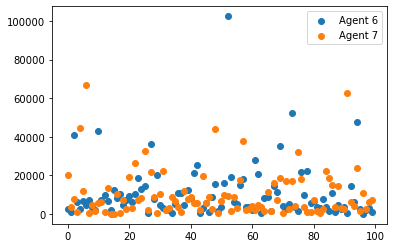

In [49]:
plt.scatter(range(0,100),cost_agent_6)
plt.scatter(range(0,100),cost_agent_7)
plt.legend(['Agent 6', 'Agent 7'])

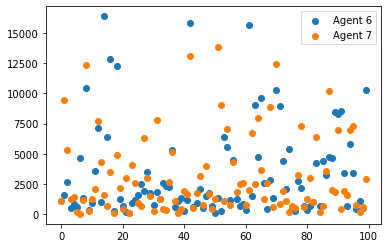

In [226]:
plt.scatter(range(0,100),examination_cost_agent_6)
plt.scatter(range(0,100),examination_cost_agent_7)
plt.legend(['Agent 6', 'Agent 7'])

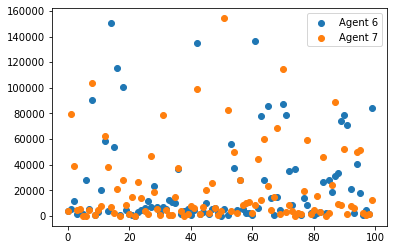

In [227]:
plt.scatter(range(0,100),movement_cost_agent_6)
plt.scatter(range(0,100),movement_cost_agent_7)
plt.legend(['Agent 6', 'Agent 7'])

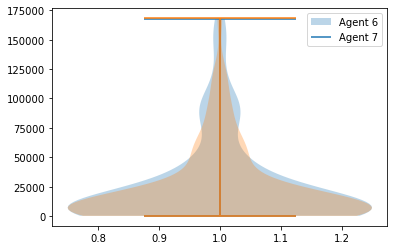

In [234]:
plt.violinplot(cost_agent_6)
plt.violinplot(cost_agent_7)
plt.legend(['Agent 6', 'Agent 7'])

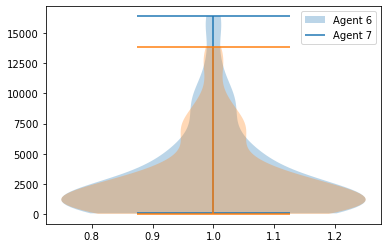

In [235]:
plt.violinplot(examination_cost_agent_6)
plt.violinplot(examination_cost_agent_7)
plt.legend(['Agent 6', 'Agent 7'])

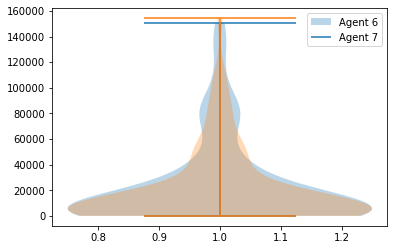

In [236]:
plt.violinplot(movement_cost_agent_6)
plt.violinplot(movement_cost_agent_7)
plt.legend(['Agent 6', 'Agent 7'])

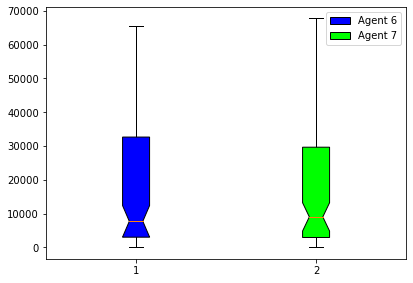

In [241]:
np.random.seed(10) 
data = [cost_agent_6, cost_agent_7] 
   
fig = plt.figure(figsize =(10, 7)) 
   
# Creating axes instance 
ax = fig.add_axes([0, 0, 0.5, 0.5]) 
   
# Creating plot 
bp = ax.boxplot(data, showfliers=False, notch=True, patch_artist = True) 

colors = ['#0000FF', '#00FF00'] 
   
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 
    
ax.legend([bp["boxes"][0], bp["boxes"][1]], ['Agent 6', 'Agent 7'])
# show plot 
plt.show() 


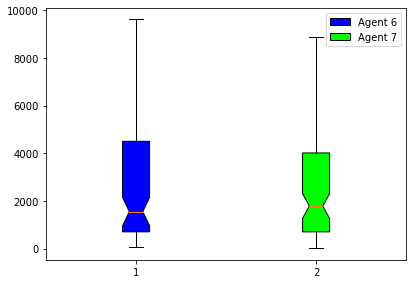

In [232]:
np.random.seed(10) 
data = [examination_cost_agent_6, examination_cost_agent_7] 
   
fig = plt.figure(figsize =(10, 7)) 
   
# Creating axes instance 
ax = fig.add_axes([0, 0, 0.5, 0.5]) 
   
# Creating plot 
bp = ax.boxplot(data, showfliers=False, notch=True, patch_artist = True) 

colors = ['#0000FF', '#00FF00'] 
   
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 
    
ax.legend([bp["boxes"][0], bp["boxes"][1]], ['Agent 6', 'Agent 7'])
# show plot 
plt.show() 


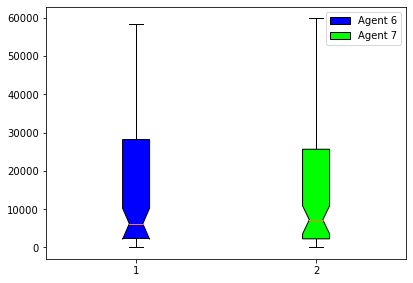

In [233]:
np.random.seed(10) 
data = [movement_cost_agent_6, movement_cost_agent_7] 
   
fig = plt.figure(figsize =(10, 7)) 
   
# Creating axes instance 
ax = fig.add_axes([0, 0, 0.5, 0.5]) 
   
# Creating plot 
bp = ax.boxplot(data, showfliers=False, notch=True, patch_artist = True) 

colors = ['#0000FF', '#00FF00'] 
   
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 
    
ax.legend([bp["boxes"][0], bp["boxes"][1]], ['Agent 6', 'Agent 7'])
# show plot 
plt.show() 


In [49]:
def make_grid(g):
    grid = []
    for i in range(50):
        a = []
        for j in range(50):
            c = cell(i,j)
            if(g[50*i+j] == 'X'):
                c.blocked = True
            else:
                if g[i+j] == 'F':
                    c.false_neg_rate = 0.8
                    c.terrain = 'Forest'
                elif g[i+j] == 'P':
                    c.false_neg_rate = 0.2
                    c.terrain = 'flat'
                else:
                    c.false_neg_rate = 0.5
                    c.terrain = 'hill'
            a.append(c)
        grid.append(a)
    return grid

In [50]:
count = 0
cost_agent_6 = []
cost_agent_7 = []
cost_agent_8 = []
examination_cost_agent_6 = []
examination_cost_agent_7 = []
examination_cost_agent_8 = []
movement_cost_agent_6 = []
movement_cost_agent_7 = []
movement_cost_agent_8 = []

with open('p0.3.txt') as f:
    g = f.readlines()
with open('project-3-srcs.pkl', 'rb') as f:
    sources = pickle.load(f)
with open('project-3-tgts.pkl', 'rb') as f:
    targets = pickle.load(f)


for i in tqdm(range(100)):
    real_world_grid = make_grid(g[i])
    real_world_grid2 = real_world_grid.copy()
    real_world_grid3 = real_world_grid.copy()
    start_cell_ind = sources[i]
    target_ind = targets[i]
    
    bot_env = gen_env(0,50)
    final_discovered_grid_world = gen_env(1,50)
    output = repeated_astar(bot_env,real_world_grid,start_cell_ind,target_ind,'m',final_discovered_grid_world,6)
    cost_6 = output[5]+output[4]
    cost_agent_6.append(cost_6)
    movement_cost_agent_6.append(output[5])
    examination_cost_agent_6.append(output[4])
    
    bot_env2 = gen_env(0,50)
    final_discovered_grid_world = gen_env(1,50)
    output = repeated_astar(bot_env2,real_world_grid2,start_cell_ind,target_ind,'m',final_discovered_grid_world,7)
    cost_7 = output[5]+output[4]
    cost_agent_7.append(cost_7)
    movement_cost_agent_7.append(output[5])
    examination_cost_agent_7.append(output[4])
    
    bot_env3 = gen_env(0,50)
    final_discovered_grid_world = gen_env(1,50)
    output = repeated_astar(bot_env3,real_world_grid3,start_cell_ind,target_ind,'m',final_discovered_grid_world,8)
    cost_8 = output[5]+output[4]
    cost_agent_8.append(cost_8)
    movement_cost_agent_8.append(output[5])
    examination_cost_agent_8.append(output[4])

100%|██████████| 100/100 [36:29<00:00, 21.89s/it]


In [51]:
sum(cost_agent_6)/100

8877.59

In [52]:
sum(cost_agent_7)/100

7288.95

In [53]:
sum(cost_agent_8)/100

8320.19

In [50]:
sum(movement_cost_agent_6)/100

5737.47

In [51]:
sum(movement_cost_agent_7)/100

6072.69

In [52]:
sum(movement_cost_agent_8)/100

4713.23

In [53]:
sum(examination_cost_agent_6)/100

3117.36

In [54]:
sum(examination_cost_agent_7)/100

3282.52

In [55]:
sum(examination_cost_agent_8)/100

2527.95

#### Comparison of agent 6 and agent 7

In [41]:
import pickle
with open('/Users/vedantgupta/Desktop/Intro to AI/Project 3/Outputs/Agent 6/Agent-6_examine_cost_100_1.pkl', 'rb') as f:
    agent_6_examine_cost = pickle.load(f)
with open('/Users/vedantgupta/Desktop/Intro to AI/Project 3/Outputs/Agent 6/Agent-6_movement_cost_100_1.pkl', 'rb') as f:
    agent_6_movement_cost = pickle.load(f)
with open('/Users/vedantgupta/Desktop/Intro to AI/Project 3/Outputs/Agent 6/Agent-6_total_cost_100_1.pkl', 'rb') as f:
    agent_6_total_cost = pickle.load(f)
with open('/Users/vedantgupta/Desktop/Intro to AI/Project 3/Outputs/Agent 7/Agent-7_examine_cost_100_1.pkl', 'rb') as f:
    agent_7_examine_cost = pickle.load(f)
with open('/Users/vedantgupta/Desktop/Intro to AI/Project 3/Outputs/Agent 7/Agent-7_movement_cost_100_1.pkl', 'rb') as f:
    agent_7_movement_cost = pickle.load(f)
with open('/Users/vedantgupta/Desktop/Intro to AI/Project 3/Outputs/Agent 7/Agent-7_total_cost_100_1.pkl', 'rb') as f:
    agent_7_total_cost = pickle.load(f)
with open('/Users/vedantgupta/Desktop/Intro to AI/Project 3/Outputs/Agent 8/Agent-8_examine_cost_100_1.pkl', 'rb') as f:
    agent_8_examine_cost = pickle.load(f)
with open('/Users/vedantgupta/Desktop/Intro to AI/Project 3/Outputs/Agent 8/Agent-8_movement_cost_100_1.pkl', 'rb') as f:
    agent_8_movement_cost = pickle.load(f)
with open('/Users/vedantgupta/Desktop/Intro to AI/Project 3/Outputs/Agent 8/Agent-8_total_cost_100_1.pkl', 'rb') as f:
    agent_8_total_cost = pickle.load(f)
with open('/Users/vedantgupta/Desktop/Intro to AI/Project 3/Outputs/Agent 9/Agent-9_examine_cost_100_1.pkl', 'rb') as f:
    agent_9_examine_cost = pickle.load(f)
with open('/Users/vedantgupta/Desktop/Intro to AI/Project 3/Outputs/Agent 9/Agent-9_movement_cost_100_1.pkl', 'rb') as f:
    agent_9_movement_cost = pickle.load(f)
with open('/Users/vedantgupta/Desktop/Intro to AI/Project 3/Outputs/Agent 9/Agent-9_total_cost_100_1.pkl', 'rb') as f:
    agent_9_total_cost = pickle.load(f)

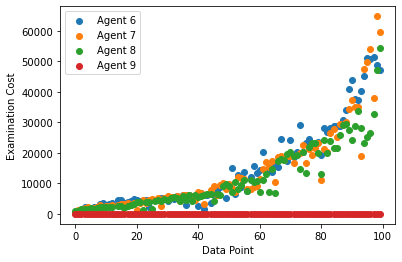

In [42]:
plt.scatter(range(100), agent_6_examine_cost)
plt.scatter(range(100), agent_7_examine_cost)
plt.scatter(range(100), agent_8_examine_cost)
plt.scatter(range(100), agent_9_examine_cost)
plt.xlabel('Data Point')
plt.ylabel('Examination Cost')
plt.legend(['Agent 6', 'Agent 7', 'Agent 8', 'Agent 9'])

<AxesSubplot:xlabel='Agent', ylabel='examine_cost'>

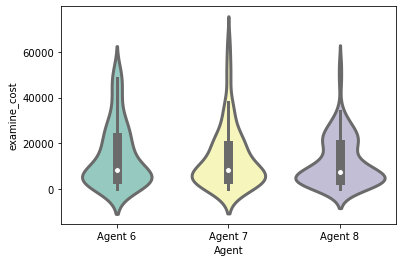

In [47]:
A1 = pd.DataFrame(agent_6_examine_cost, columns=['examine_cost'])
A1['Agent'] = "Agent 6"
A2 = pd.DataFrame(agent_7_examine_cost, columns=['examine_cost'])
A2['Agent'] = "Agent 7"
A3 = pd.DataFrame(agent_8_examine_cost, columns=['examine_cost'])
A3['Agent'] = "Agent 8"
# A4 = pd.DataFrame(agent_9_examine_cost, columns=['examine_cost'])
# A4['Agent'] = "Agent 9"
data = pd.concat([A1, A2, A3])
sns.violinplot(x='Agent',y='examine_cost',data=data, inner="box", palette="Set3", cut=2, linewidth=3)

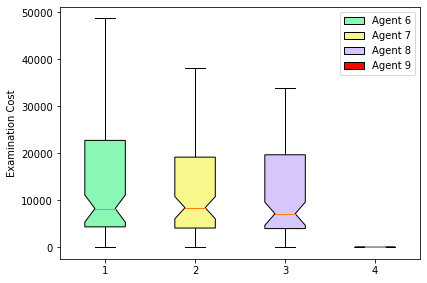

In [49]:
np.random.seed(10) 
data = [agent_6_examine_cost, agent_7_examine_cost, agent_8_examine_cost, agent_9_examine_cost] 
   
fig = plt.figure(figsize =(10, 7)) 
   
# Creating axes instance 
ax = fig.add_axes([0, 0, 0.5, 0.5]) 
   
# Creating plot 
bp = ax.boxplot(data, showfliers=False, notch=True, patch_artist = True) 

colors = ['#8BF7B5', '#F7F78B', '#D6C6FC', '#FF0000'] 
   
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 
    
ax.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2], bp["boxes"][3]], ['Agent 6', 'Agent 7', 'Agent 8', 'Agent 9'])
# ax.legend([bp["boxes"][0], bp["boxes"][1]], ['Agent 6', 'Agent 7'])
# show plot
plt.ylabel('Examination Cost')
plt.show() 

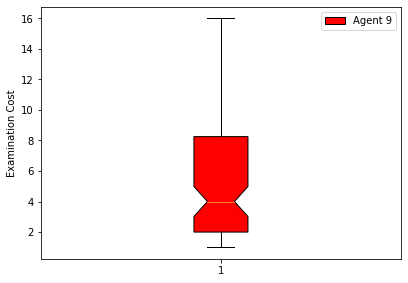

In [57]:
np.random.seed(10) 
data = [agent_9_examine_cost] 
   
fig = plt.figure(figsize =(10, 7)) 
   
# Creating axes instance 
ax = fig.add_axes([0, 0, 0.5, 0.5]) 
   
# Creating plot 
bp = ax.boxplot(data, showfliers=False, notch=True, patch_artist = True) 

colors = ['#FF0000'] 
   
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 
    
ax.legend([bp["boxes"][0]], ['Agent 9'])
# ax.legend([bp["boxes"][0], bp["boxes"][1]], ['Agent 6', 'Agent 7'])
# show plot
plt.ylabel('Examination Cost')
plt.show() 

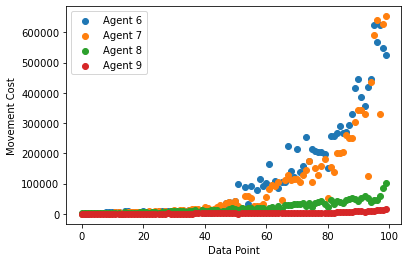

In [50]:
plt.scatter(range(100), agent_6_movement_cost)
plt.scatter(range(100), agent_7_movement_cost)
plt.scatter(range(100), agent_8_movement_cost)
plt.scatter(range(100), agent_9_movement_cost)
plt.xlabel('Data Point')
plt.ylabel('Movement Cost')
plt.legend(['Agent 6', 'Agent 7', 'Agent 8', 'Agent 9'])

<AxesSubplot:xlabel='Agent', ylabel='movement_cost'>

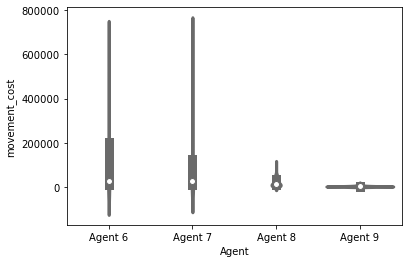

In [52]:
A1 = pd.DataFrame(agent_6_movement_cost, columns=['movement_cost'])
A1['Agent'] = "Agent 6"
A2 = pd.DataFrame(agent_7_movement_cost, columns=['movement_cost'])
A2['Agent'] = "Agent 7"
A3 = pd.DataFrame(agent_8_movement_cost, columns=['movement_cost'])
A3['Agent'] = "Agent 8"
A4 = pd.DataFrame(agent_9_movement_cost, columns=['movement_cost'])
A4['Agent'] = "Agent 9"
data = pd.concat([A1, A2, A3, A4])
sns.violinplot(x='Agent',y='movement_cost',data=data, inner="box", palette="Set3", cut=2, linewidth=3)

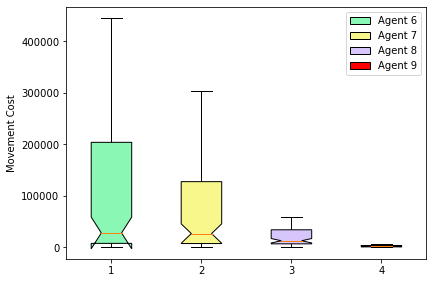

In [53]:
np.random.seed(10) 
data = [agent_6_movement_cost, agent_7_movement_cost, agent_8_movement_cost, agent_9_movement_cost] 
   
fig = plt.figure(figsize =(10, 7)) 
   
# Creating axes instance 
ax = fig.add_axes([0, 0, 0.5, 0.5]) 
   
# Creating plot 
bp = ax.boxplot(data, showfliers=False, notch=True, patch_artist = True) 

colors = ['#8BF7B5', '#F7F78B', '#D6C6FC', '#FF0000']
   
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 
    
ax.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2], bp["boxes"][3]], ['Agent 6', 'Agent 7', 'Agent 8', 'Agent 9'])
# ax.legend([bp["boxes"][0], bp["boxes"][1]], ['Agent 6', 'Agent 7'])
# show plot 
plt.ylabel('Movement Cost')
plt.show() 


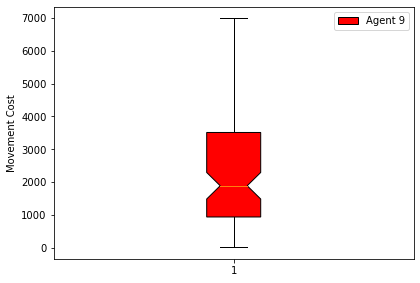

In [58]:
np.random.seed(10) 
data = [agent_9_movement_cost] 
   
fig = plt.figure(figsize =(10, 7)) 
   
# Creating axes instance 
ax = fig.add_axes([0, 0, 0.5, 0.5]) 
   
# Creating plot 
bp = ax.boxplot(data, showfliers=False, notch=True, patch_artist = True) 

colors = ['#FF0000'] 
   
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 
    
ax.legend([bp["boxes"][0]], ['Agent 9'])
# ax.legend([bp["boxes"][0], bp["boxes"][1]], ['Agent 6', 'Agent 7'])
# show plot
plt.ylabel('Movement Cost')
plt.show() 

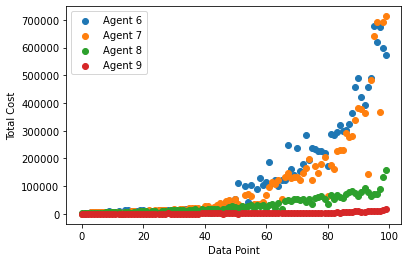

In [55]:
plt.scatter(range(100), agent_6_total_cost)
plt.scatter(range(100), agent_7_total_cost)
plt.scatter(range(100), agent_8_total_cost)
plt.scatter(range(100), agent_9_total_cost)
plt.xlabel('Data Point')
plt.ylabel('Total Cost')
plt.legend(['Agent 6', 'Agent 7', 'Agent 8', 'Agent 9'])

<AxesSubplot:xlabel='Agent', ylabel='total_cost'>

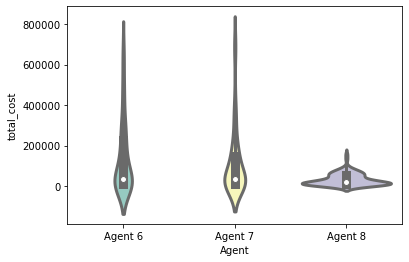

In [72]:
A1 = pd.DataFrame(agent_6_total_cost, columns=['total_cost'])
A1['Agent'] = "Agent 6"
A2 = pd.DataFrame(agent_7_total_cost, columns=['total_cost'])
A2['Agent'] = "Agent 7"
A3 = pd.DataFrame(agent_8_total_cost, columns=['total_cost'])
A3['Agent'] = "Agent 8"
data = pd.concat([A1, A2, A3])
sns.violinplot(x='Agent',y='total_cost',data=data, inner="box", palette="Set3", cut=2, linewidth=3)

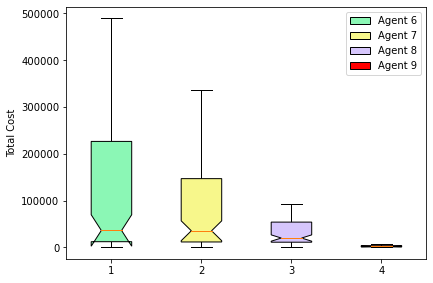

In [56]:
np.random.seed(10) 
data = [agent_6_total_cost, agent_7_total_cost, agent_8_total_cost, agent_9_total_cost] 
   
fig = plt.figure(figsize =(10, 7)) 
   
# Creating axes instance 
ax = fig.add_axes([0, 0, 0.5, 0.5]) 
   
# Creating plot 
bp = ax.boxplot(data, showfliers=False, notch=True, patch_artist = True) 

colors = ['#8BF7B5', '#F7F78B', '#D6C6FC', '#FF0000']
   
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 
    
ax.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2], bp["boxes"][3]], ['Agent 6', 'Agent 7', 'Agent 8', 'Agent 9'])
# ax.legend([bp["boxes"][0], bp["boxes"][1]], ['Agent 6', 'Agent 7'])
# show plot 
plt.ylabel('Total Cost')
plt.show() 


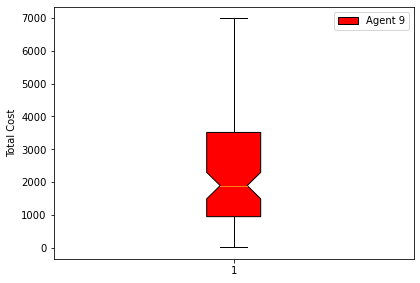

In [59]:
np.random.seed(10) 
data = [agent_9_total_cost] 
   
fig = plt.figure(figsize =(10, 7)) 
   
# Creating axes instance 
ax = fig.add_axes([0, 0, 0.5, 0.5]) 
   
# Creating plot 
bp = ax.boxplot(data, showfliers=False, notch=True, patch_artist = True) 

colors = ['#FF0000'] 
   
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 
    
ax.legend([bp["boxes"][0]], ['Agent 9'])
# ax.legend([bp["boxes"][0], bp["boxes"][1]], ['Agent 6', 'Agent 7'])
# show plot
plt.ylabel('Total Cost')
plt.show() 

Text(0.5, 1.0, 'Density plot for movement cost/examination cost')

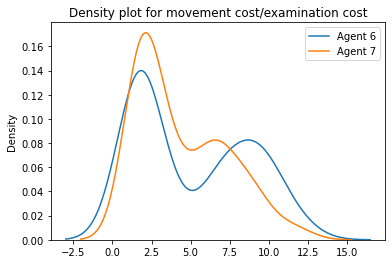

In [61]:
sns.kdeplot([i/j for i,j in zip(agent_6_movement_cost,agent_6_examine_cost)])
sns.kdeplot([i/j for i,j in zip(agent_7_movement_cost,agent_7_examine_cost)])
# sns.kdeplot([i/j for i,j in zip(agent_8_movement_cost,agent_8_examine_cost)])
plt.legend(['Agent 6', 'Agent 7'])
plt.title('Density plot for movement cost/examination cost')

Text(0.5, 1.0, 'Density plot for movement cost')

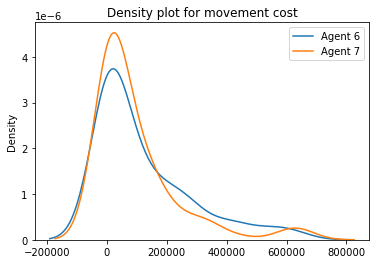

In [62]:
sns.kdeplot(agent_6_movement_cost)
sns.kdeplot(agent_7_movement_cost)
# sns.kdeplot(agent_8_movement_cost)
plt.legend(['Agent 6', 'Agent 7'])#, 'Agent 8'])
plt.title('Density plot for movement cost')

Text(0.5, 1.0, 'Density plot for examination cost')

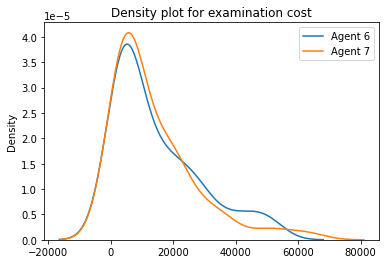

In [64]:
sns.kdeplot(agent_6_examine_cost)
sns.kdeplot(agent_7_examine_cost)
# sns.kdeplot(agent_8_examine_cost)
plt.legend(['Agent 6', 'Agent 7'])#, 'Agent 8'])
plt.title('Density plot for examination cost')